In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [3]:
def load_wham2d(fname):
    headers = []
    data = []
    with open(fname) as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line[0] == "#":
                headers = line[1:].split()
            else:
                line_list = line.split()
                data.append([float(i) for i in line_list])
    return pd.DataFrame(data=data, columns=headers)

In [29]:
KbT = 300 * 8.314 # J/mol
FE_data = load_wham2d("fdat.dat")
FE_data.Free = FE_data.Free.replace(np.inf, np.nan)
FE_data.dropna(inplace=True)
FE_data.Free += KbT*2*np.log(FE_data.X)/1000
print(FE_data.Free.max(), FE_data.Free.min())

60.271675792936996 -9.20439737092277


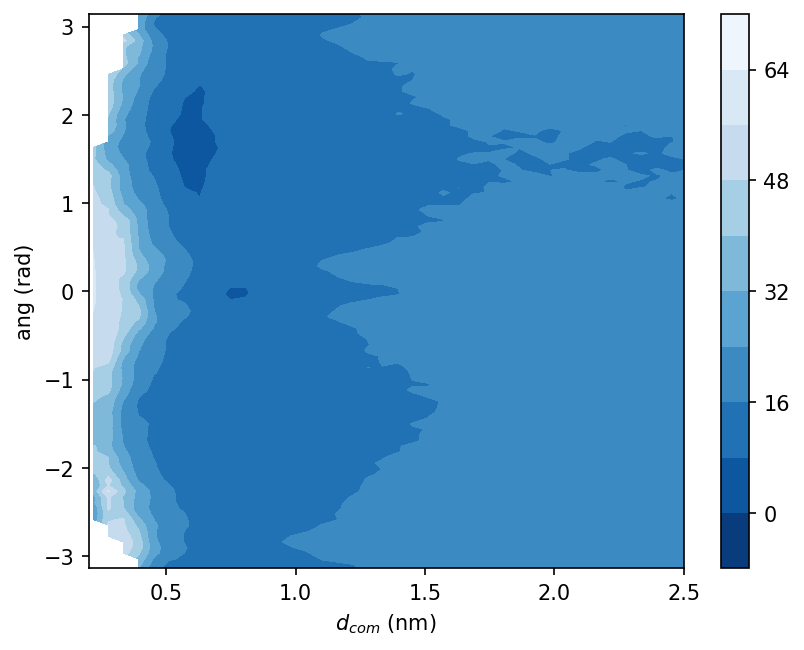

In [30]:
X_plot = np.linspace(FE_data.X.min(), FE_data.X.max(), 50)
Y_plot = np.linspace(FE_data.Y.min(), FE_data.Y.max(), 100)
Z_plot = griddata((FE_data.X, FE_data.Y), FE_data.Free, (X_plot[None,:], Y_plot[:,None]), method='cubic')
Z_plot = np.nan_to_num(Z_plot, nan=np.inf)
fig, ax = plt.subplots(1, 1, dpi=150)
CS = ax.contourf(X_plot, Y_plot, Z_plot, 10, cmap=plt.cm.Blues_r)#, vmax=70, vmin=-10.0)
cb = fig.colorbar(CS)#, ticks=np.linspace(-20, 60, 21))
ax.set_xlabel(r"$d_{com}$ (nm)")
ax.set_ylabel("ang (rad)")
ax.set_xlim(0.2, 2.5)
ax.set_ylim(-np.pi, np.pi)
plt.show()

In [1]:
from scipy.integrate import simpson

def calc_FE_2d(FE_data, rbase: dict, pbase: dict) -> float:
    """
    2D integration of the FE surface to calculate FE difference between a reactanct and a product basin.

    args:
        X (np.ndarray): numpy array of colvar 1
        Y (np.ndarray): numpy array of colvar 2
        weights (np.ndarray): numpy array of weights from reweighting run
        rbase (dict): dict defining reactant basin ["X": (x_min, x_max), "Y": (y_min, y_max)]
        pbase (dict): dict defining product basin ["X": (x_min, x_max), "Y": (y_min, y_max)]
    
    returns:
        dFE: Free energy difference between reactant and product
    """
    FE_data.Free += KbT*2*np.log(FE_data.X)/1000
    FE_data["exp"] = np.exp(-FE_data.Free*1000/KbT)

    Y_integrand = {"r":{"X": [], "exp":[]}, "p":{"X": [], "exp":[]}}
    # integrate over Y
    for x in FE_data.X.unique():
        FE_this_x = FE_data[FE_data.X == x]
        # reactant
        Y_integrand["r"]["X"].append(x)
        FE_this_x_r = FE_this_x[(FE_this_x.Y>rbase["Y"][0]) & (FE_this_x.Y<rbase["Y"][1])]
        Y_integrand["r"]["exp"].append(simpson(y=FE_this_x_r.exp.to_numpy(), x=FE_this_x_r.Y.to_numpy()))
        # product
        Y_integrand["p"]["X"].append(x)
        FE_this_x_p = FE_this_x[(FE_this_x.Y>pbase["Y"][0]) & (FE_this_x.Y<pbase["Y"][1])]
        Y_integrand["p"]["exp"].append(simpson(y=FE_this_x_p.exp.to_numpy(), x=FE_this_x_p.Y.to_numpy()))
    
    Y_integrand_r = pd.DataFrame(Y_integrand["r"])
    Y_integrand_r = Y_integrand_r[(Y_integrand_r.X>rbase["X"][0]) & (Y_integrand_r.X<rbase["X"][1])]
    Y_integrand_p = pd.DataFrame(Y_integrand["p"])
    Y_integrand_p = Y_integrand_p[(Y_integrand_p.X>pbase["X"][0]) & (Y_integrand_p.X<pbase["X"][1])]
    # integrate over X
    # reactant
    r_integrand = simpson(y=Y_integrand_r.exp.to_numpy(), x=Y_integrand_r.X.to_numpy())
    # product
    p_integrand = simpson(y=Y_integrand_p.exp.to_numpy(), x=Y_integrand_p.X.to_numpy())
    
    return -KbT*np.log(p_integrand/r_integrand)/1000

In [6]:
KbT = 300 * 8.314 # J/mol
FE_data = load_wham2d("fdat.dat")
FE_data.dropna(inplace=True)
FE_val = calc_FE_2d(FE_data, {"X": (0.5, 1.0), "Y": (-np.pi, np.pi)}, {"X": (2.0, 2.5), "Y": (-np.pi, np.pi)})
print(f"Free energy diff = {FE_val:.3f} kJ/Mol")

Free energy diff = 6.679 kJ/Mol
